In [1]:
import torch
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display_html

def get_ema(arr, gamma = 0.01):
    ema = 0.0
    for v in arr:
        ema = ema * (1 - gamma) + gamma * v
    return v

def get_loss_dyn(dname):
    ann_file = f'/mnt/ssd2/sc_datasets_det/{dname}/annotations/instances_train_16_1_noise.json'
    img_prefix = f'/mnt/ssd2/sc_datasets_det/{dname}/images/train'

    with open(ann_file, "r") as fp:
        anno = json.load(fp)

    ckpt = torch.load(os.path.join("noise_output", "16", dname, "latest.pth"))
    loss_dynamics = ckpt["meta"]["loss_dynamics"]

    dfs = []

    for k, data in loss_dynamics.items():
        df = pd.DataFrame([(a_id, get_ema(v)) for a_id, v in data.items()], columns=["id", f"{k}_ema"])
        df = df.set_index("id")
        dfs.append(df)

    df = pd.concat(dfs, axis=1)
    
    noise_label = {ann["id"]: ann["noise"] for ann in anno["annotations"]}
    df["noise"] = df.index.map(lambda x: noise_label[x])
    df["bbox_shift"] = df["noise"] == 1
    df["cls_shift"] = df["noise"] == 2

    # tmp = df["len"]
    # del df["len"]

    df.columns = ["Classification", "Bbox", "Centerness"] + df.columns[3:].values.tolist()
    # df["length"] = df["Classification"].apply(lambda x: len(x))
    return df

In [2]:
dfs = {
    dname: get_loss_dyn(dname)
    for dname in ["aerial-maritime", "d6-dice", "bccd", "pklot"]
}

In [3]:
for dname, df in dfs.items():
    display_html(df.groupby("noise").mean().style.set_caption(dname))

,Classification,Bbox,Centerness,bbox_shift,cls_shift
noise,,,,,
0,0.028327,0.195403,0.596045,False,False
1,0.032722,0.380558,0.648618,True,False
2,0.060079,0.179631,0.558229,False,True


,Classification,Bbox,Centerness,bbox_shift,cls_shift
noise,,,,,
0,0.047584,0.172016,0.604662,False,False
1,0.095279,0.479025,0.607433,True,False
2,0.046000,0.126248,0.624980,False,True


,Classification,Bbox,Centerness,bbox_shift,cls_shift
noise,,,,,
0,0.018784,0.166830,0.575613,False,False
1,0.070615,0.359968,0.610430,True,False
2,0.116176,0.143595,0.564606,False,True


,Classification,Bbox,Centerness,bbox_shift,cls_shift
noise,,,,,
0,0.035177,0.263989,0.615487,False,False
1,0.114132,0.507177,0.639634,True,False
2,0.134529,0.292378,0.598235,False,True


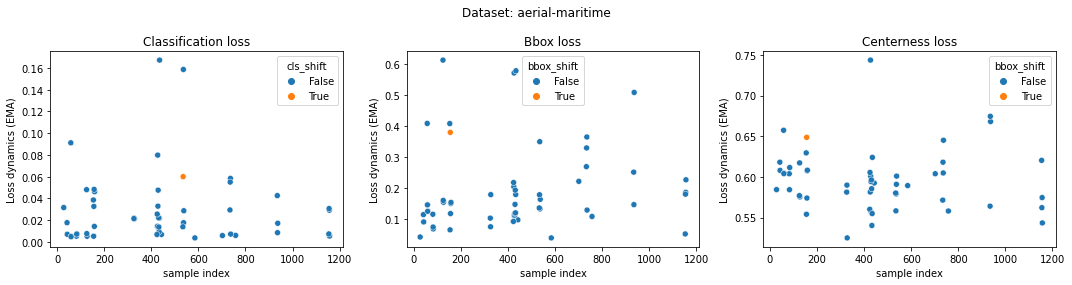

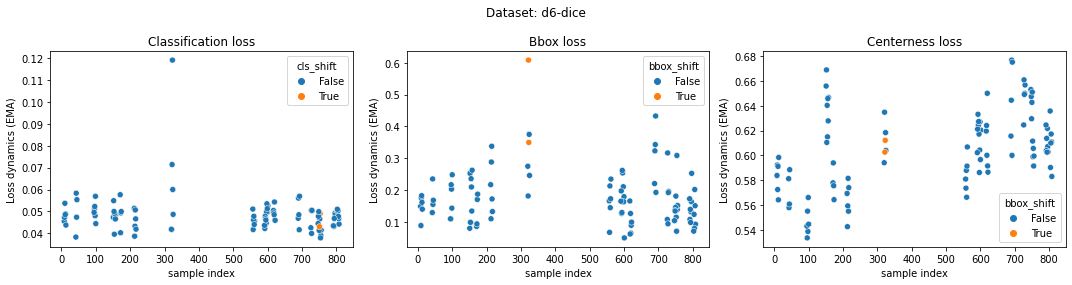

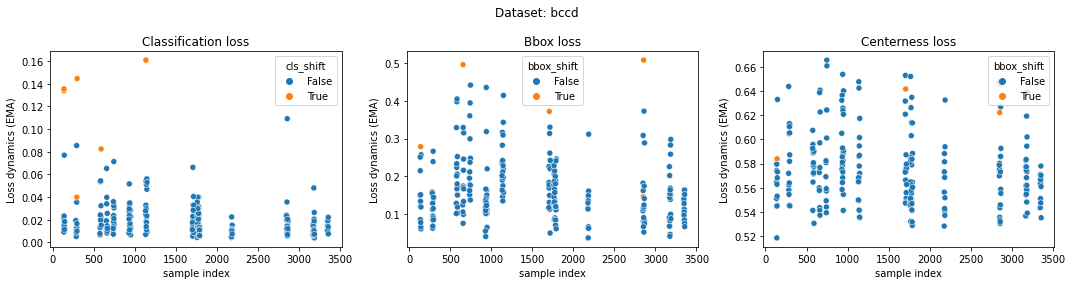

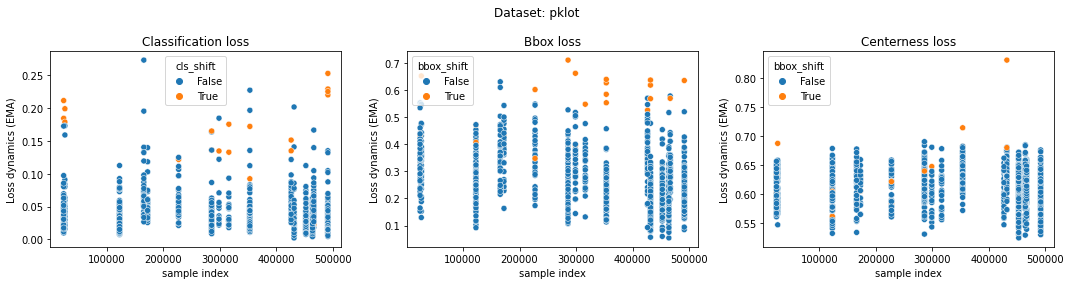

In [6]:
for row, (dname, df) in enumerate(dfs.items()):
    plt.subplots(1, 3, figsize=(5 * 3, 4))
    idx = 0
    for col in df.columns[:3]:
        idx += 1
        hue = "cls_shift" if col == "Classification" else "bbox_shift"
        plt.subplot(1, 3, idx)
        splot = sns.scatterplot(x="id", y=col, hue=hue, data=df)
        splot.set(title=f"{col} loss")
        splot.set(ylabel="Loss dynamics (EMA)", xlabel="sample index")
    
    plt.suptitle(f"Dataset: {dname}")
    plt.tight_layout()
    plt.show()

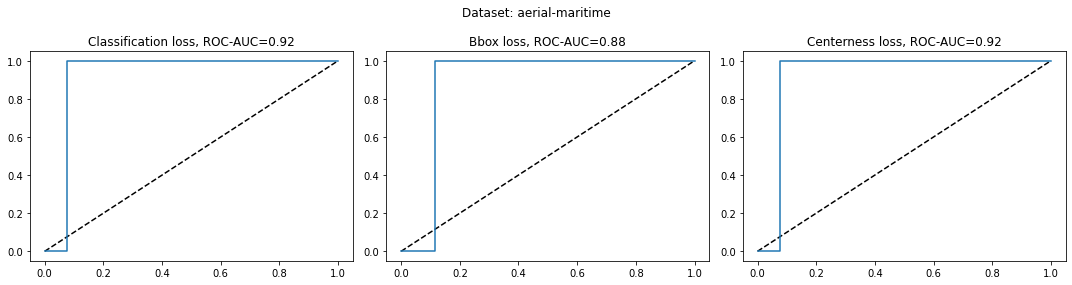

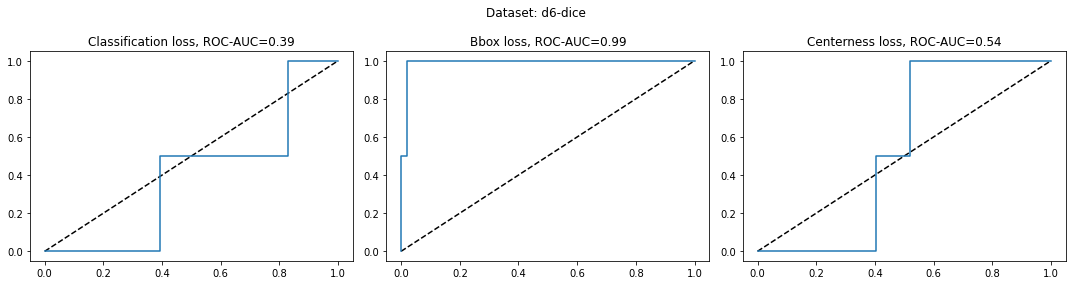

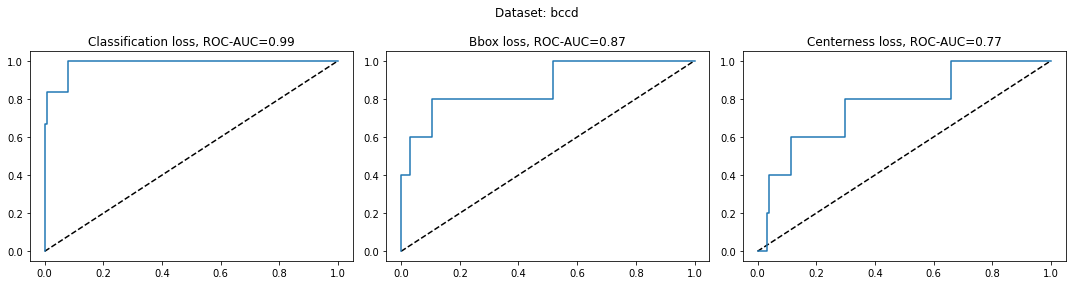

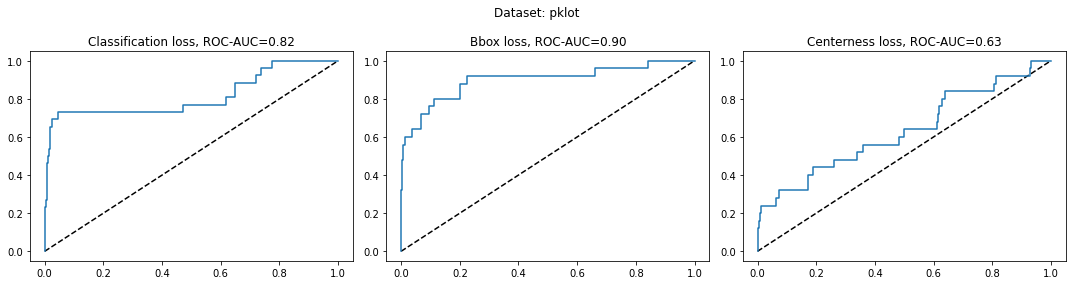

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

for row, (dname, df) in enumerate(dfs.items()):
    plt.subplots(1, 3, figsize=(5 * 3, 4))
    idx = 0
    for col in df.columns[:3]:
        idx += 1
        hue = "cls_shift" if col == "Classification" else "bbox_shift"

        fpr, tpr, thresholds = roc_curve(df[hue], df[col], pos_label=1)
        score = roc_auc_score(df[hue], df[col])

        plt.subplot(1, 3, idx)
        plt.plot(np.linspace(0, 1.0), np.linspace(0, 1.0), color="k", linestyle="--")
        plt.plot(fpr, tpr, label=col)
        plt.title(f"{col} loss, ROC-AUC={score:.2f}")

    plt.suptitle(f"Dataset: {dname}")
    plt.tight_layout()
    plt.show()